In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
import torch
from torch import tensor, as_tensor, float32, ones, zeros, eye, randn, rand, Tensor

from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian

from gbi.GBI import GBInference
from gbi.distances import mse_dist
from gbi.utils import utils as gbi_utils

from sbi.inference import MCMCPosterior, SNLE, SNPE, MCABC
from sbi.utils import mcmc_transform


In [58]:
task = UniformNoise1D(beta = 50)
theta = task.prior.sample((500,))
x = task.simulate(theta)

noise_level = 2
# augment training data with noise
x_aug = x + torch.randn(x.shape)*x.std(dim=0) * noise_level
x_target = torch.concat((x,x_aug[:100]),dim=0)

In [59]:
inference = GBInference(prior=task.prior, distance_func=mse_dist)
inference = inference.append_simulations(theta, x, x_target)
inference.initialize_distance_estimator(3,128, 'resnet', positive_constraint_fn='softplus')

In [69]:
torch.randint(x.shape[0], size=(10,))

tensor([353, 371, 441, 161, 209, 339, 357, 284, 331,  60])

In [18]:
gbi_utils.pickle_dump('./npe.pickle', inference)

/home/rdgao/Documents/code/research/neuralgbi/packages/sbi/sbi/inference/base.py:429: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(


In [19]:
inference_new = gbi_utils.pickle_load('./npe.pickle')

In [46]:
p_new = [k for k in inference_new._neural_net.parameters()]
p_old = [k for k in density_estimator.parameters()]

In [53]:
p_new[2]==p_old[2]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [37]:
posterior = inference_new.build_posterior(inference_new._neural_net)
x_o = Tensor([.75])
posterior.set_default_x(x_o)
samples = posterior.sample((100,))

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

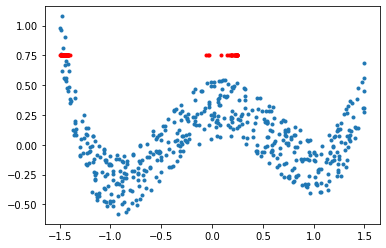

In [38]:
plt.plot(theta,x, '.')
plt.plot(samples, x_o * ones(samples.size()), '.r')

In [70]:
inference = gbi_utils.pickle_load('../gbi/benchmark/tasks/two_moons/trained_inference/GBI.pickle')

In [74]:
inference.get_potential()

0: train loss: 0.025554, val loss: 0.030304
20: train loss: 0.015579, val loss: 0.015452
40: train loss: 0.015875, val loss: 0.015473
60: train loss: 0.016175, val loss: 0.014904
80: train loss: 0.014602, val loss: 0.014902
100: train loss: 0.013413, val loss: 0.014380
120: train loss: 0.013990, val loss: 0.014072
140: train loss: 0.014070, val loss: 0.013806
160: train loss: 0.014523, val loss: 0.013514
180: train loss: 0.014358, val loss: 0.013453
200: train loss: 0.012484, val loss: 0.013255
Network converged after 207 of 500 epochs.


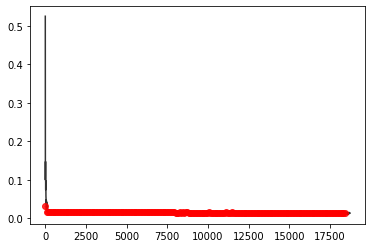

In [59]:
# distance_net = inference.train(training_batch_size=inference.x_target.shape[0], max_n_epochs=100)
distance_net = inference.train(training_batch_size=int(inference.idx_train.shape[0]/100), max_n_epochs=500, stop_after_counter_reaches=20)

In [39]:
x_o = Tensor([-0.2])
potential_fn = inference.get_potential(x_o=x_o, beta=task.beta)

theta_transform = mcmc_transform(task.prior)
posterior = MCMCPosterior(
        potential_fn,
        theta_transform=theta_transform,
        proposal=task.prior,
        method="slice_np_vectorized",
        thin=10,
        warmup_steps=50,
        num_chains=100,
        init_strategy="resample",
    )
samples = posterior.sample((10_000,))

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

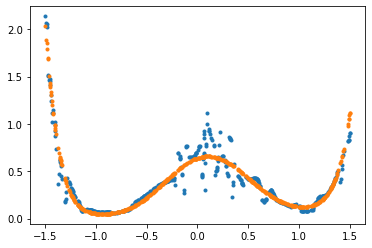

In [67]:
x_o = Tensor([-0.5])
task.x_o = x_o
gt = task.distance_fn(theta)
plt.plot(theta, inference.distance_net(theta, x_o.unsqueeze(1).repeat(theta.shape[0],1)).detach().numpy(), '.')
plt.plot(theta, gt, '.')
# plt.plot(theta, ((x-x_o).pow(2)), '.')
# plt.plot(samples, ones(samples.shape[0]), '.', alpha=0.2)

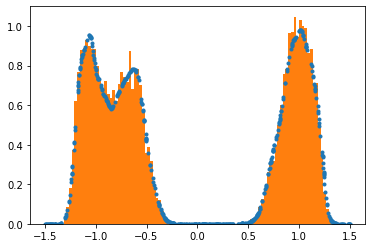

In [42]:
plt.plot(theta,potential_fn(theta).detach().exp()*10, '.')
plt.hist(samples.squeeze(), 100, density=True);

# Two moons

In [36]:
task = TwoMoonsGBI(beta = 100)
theta = task.prior.sample((500,))
x = task.simulate(theta)

noise_level = 2
# augment training data with noise
x_aug = x + torch.randn(x.shape)*x.std(dim=0) * noise_level
x_target = torch.concat((x,x_aug[:100]),dim=0)

In [37]:
# task.x_o = x_target[100]
# plt.plot(task.distance_fn(theta), (x-task.x_o).pow(2).mean(1), '.')

In [38]:
inference = GBInference(prior=task.prior, distance_func=mse_dist)
inference = inference.append_simulations(theta, x, x_target)
inference.initialize_distance_estimator(3,128, 'MLP', positive_constraint_fn='softplus')

0: train loss: 0.018024, val loss: 0.017590
20: train loss: 0.005622, val loss: 0.005364
40: train loss: 0.005569, val loss: 0.005236
60: train loss: 0.006201, val loss: 0.005099
80: train loss: 0.005022, val loss: 0.005269
100: train loss: 0.005639, val loss: 0.004793
120: train loss: 0.004338, val loss: 0.004803
140: train loss: 0.004471, val loss: 0.005014
160: train loss: 0.004365, val loss: 0.004594
180: train loss: 0.004149, val loss: 0.004409
200: train loss: 0.004097, val loss: 0.004183
220: train loss: 0.003490, val loss: 0.003956
240: train loss: 0.003748, val loss: 0.003668
260: train loss: 0.003003, val loss: 0.003629
280: train loss: 0.003340, val loss: 0.003600
300: train loss: 0.003192, val loss: 0.003331
320: train loss: 0.003058, val loss: 0.003541
340: train loss: 0.003206, val loss: 0.003210
360: train loss: 0.002741, val loss: 0.002980
380: train loss: 0.002477, val loss: 0.002962
400: train loss: 0.002461, val loss: 0.003081
420: train loss: 0.002330, val loss: 0.0

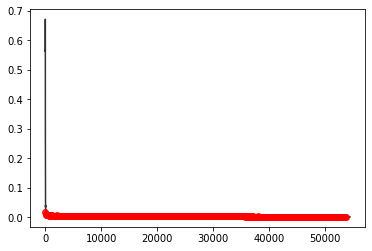

In [39]:
distance_net = inference.train(training_batch_size=int(inference.idx_train.shape[0]/100), max_n_epochs=1000, stop_after_counter_reaches=20)

In [148]:
x_o = Tensor([-0.2, 0.2])

task = TwoMoonsGBI(beta=100, x_o=x_o)
theta_dense = task.prior.sample((1000,))
x_dense = task.simulate(theta_dense)



dist_sim = (x_dense - x_o).pow(2).mean(1)
dist_gt = task.distance_fn(theta_dense)

x_o = x_target[130]
# task.x_o = x_o

task.set_x_o(x_o)
dist_gt = task.distance_fn(theta_dense)
dist_sim = (x_dense - x_o).pow(2).mean(1)

dist = inference.distance_net(theta_dense, x_o.repeat(theta_dense.shape[0],1))


lh_gt = task.potential(theta_dense)
potential_fn = inference.get_potential(x_o=x_o, beta=task.beta)
lh = potential_fn(theta_dense)


In [149]:
potential_fn = inference.get_potential(x_o=task.x_o, beta=task.beta)

theta_transform = mcmc_transform(task.prior)
posterior = MCMCPosterior(
        potential_fn,
        theta_transform=theta_transform,
        proposal=task.prior,
        method="slice_np_vectorized",
        thin=10,
        warmup_steps=50,
        num_chains=100,
        init_strategy="resample",
    )
samples = posterior.sample((10_00,))

Running vectorized MCMC with 100 chains:   0%|          | 0/60000 [00:00<?, ?it/s]

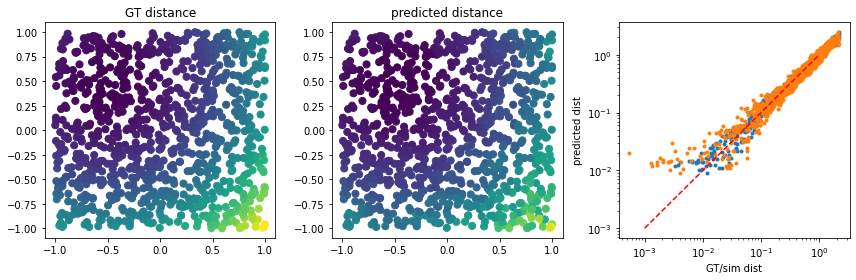

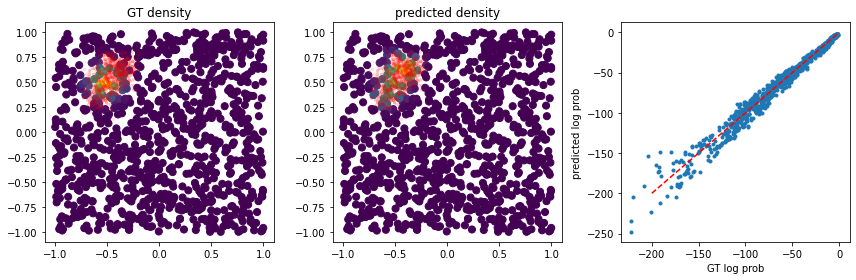

In [153]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(theta_dense[:,0], theta_dense[:,1], c=dist_gt, s=50)
plt.title('GT distance')

plt.subplot(1,3,2)
plt.scatter(theta_dense[:,0], theta_dense[:,1], c=dist.detach(), s=50)
plt.title('predicted distance')

plt.subplot(1,3,3)
plt.loglog(dist_gt, dist.detach(), '.')
plt.loglog(dist_sim, dist.detach(), '.')

plt.plot([1e-3,1], [1e-3,1], 'r--')
plt.xlabel('GT/sim dist');plt.ylabel('predicted dist');
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(theta_dense[:,0], theta_dense[:,1], c=lh_gt.exp(), s=50)
plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.1)
plt.title('GT density')

plt.subplot(1,3,2)
plt.scatter(theta_dense[:,0], theta_dense[:,1], c=lh.exp().detach(), s=50)
plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.1)
plt.title('predicted density')

plt.subplot(1,3,3)
plt.plot(lh_gt, lh.detach(), '.')
plt.xlabel('GT log prob');plt.ylabel('predicted log prob');
plt.plot([-200,0], [-200,0], 'r--')
plt.tight_layout()

# plt.figure()
# plt.loglog(dist_sim, dist_gt, '.')
# plt.loglog(dist_sim, dist.detach(), '.')
# plt.plot([1e-3,1], [1e-3,1], 'r--')